# Анализ Secure Water Treatment (SWaT)
**Цель:** Исследовать различия между периодами атаки и нормальной работы сети, выявить закономерности и построить модель классификации.

**Метрики:**

*   F1-score (баланс между precision и recall, если классы несбалансированы)
*   Precision
*   Recall
*   ROC-AUC (оценка качества разделения классов)
*   Accuracy
*   Confusion Matrix (наглядная интерпретация ошибок)


In [35]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report,
                            confusion_matrix,
                            roc_auc_score,
                            roc_curve,
                            precision_recall_curve,
                            average_precision_score)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
data = pd.read_csv('/content/SWaT_Dataset_Attack_v0.csv', sep=';', decimal=',')
print(data)

                      Timestamp    FIT101    LIT101  MV101  P101  P102  \
0        28/12/2015 10:00:00 AM  2.427057  522.8467      2     2     1   
1        28/12/2015 10:00:01 AM  2.446274  522.8860      2     2     1   
2        28/12/2015 10:00:02 AM  2.489191  522.8467      2     2     1   
3        28/12/2015 10:00:03 AM  2.534350  522.9645      2     2     1   
4        28/12/2015 10:00:04 AM  2.569260  523.4748      2     2     1   
...                         ...       ...       ...    ...   ...   ...   
449914      2/1/2016 2:59:55 PM  2.559972  519.5495      2     2     1   
449915      2/1/2016 2:59:56 PM  2.549082  520.4131      2     2     1   
449916      2/1/2016 2:59:57 PM  2.531467  520.6878      2     2     1   
449917      2/1/2016 2:59:58 PM  2.521218  520.7271      2     2     1   
449918      2/1/2016 2:59:59 PM  2.501681  521.1196      2     2     1   

          AIT201    AIT202    AIT203    FIT201  ...  P501  P502    PIT501  \
0       262.0161  8.396437  328.63

Кстати в последней версии файла с данными целевая переменная атаки в 37 строках была представлена как A ttack вместо Attack. Из-за чего у меня изначально выезжало 3 класса.

In [37]:
data = data.replace('A ttack', 'Attack')
print(data)

                      Timestamp    FIT101    LIT101  MV101  P101  P102  \
0        28/12/2015 10:00:00 AM  2.427057  522.8467      2     2     1   
1        28/12/2015 10:00:01 AM  2.446274  522.8860      2     2     1   
2        28/12/2015 10:00:02 AM  2.489191  522.8467      2     2     1   
3        28/12/2015 10:00:03 AM  2.534350  522.9645      2     2     1   
4        28/12/2015 10:00:04 AM  2.569260  523.4748      2     2     1   
...                         ...       ...       ...    ...   ...   ...   
449914      2/1/2016 2:59:55 PM  2.559972  519.5495      2     2     1   
449915      2/1/2016 2:59:56 PM  2.549082  520.4131      2     2     1   
449916      2/1/2016 2:59:57 PM  2.531467  520.6878      2     2     1   
449917      2/1/2016 2:59:58 PM  2.521218  520.7271      2     2     1   
449918      2/1/2016 2:59:59 PM  2.501681  521.1196      2     2     1   

          AIT201    AIT202    AIT203    FIT201  ...  P501  P502    PIT501  \
0       262.0161  8.396437  328.63

In [39]:
print(f"Размер датасета: {data.shape}")
print("\nИнформация о данных:")
print(data.info())
print("\nСтатистика:")
print(data.describe())

Размер датасета: (449919, 53)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449919 entries, 0 to 449918
Data columns (total 53 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      449919 non-null  object 
 1   FIT101         449919 non-null  float64
 2   LIT101         449919 non-null  float64
 3   MV101          449919 non-null  int64  
 4   P101           449919 non-null  int64  
 5   P102           449919 non-null  int64  
 6   AIT201         449919 non-null  float64
 7   AIT202         449919 non-null  float64
 8   AIT203         449919 non-null  float64
 9   FIT201         449919 non-null  float64
 10  MV201          449919 non-null  int64  
 11  P201           449919 non-null  int64  
 12  P202           449919 non-null  int64  
 13  P203           449919 non-null  int64  
 14  P204           449919 non-null  int64  
 15  P205           449919 non-null  int64  
 16  P206           449919 

В датасете промышленной системы водоснабжения (SWaT) используются стандартные обозначения параметров, которые можно расшифровать как:
FIT - Flow Indicator Transmitter (датчик расхода)

LIT - Level Indicator Transmitter (датчик уровня)

AIT - Analytical Indicator Transmitter (аналитический датчик, обычно температура/хим.состав)

PIT - Pressure Indicator Transmitter (датчик давления)

DPIT - Differential Pressure Indicator (датчик перепада давления)

MV - Motor Valve (электромагнитный клапан)

P - Pump (насос)

UV - Ultraviolet (ультрафиолетовый датчик/лампа)

In [38]:
print("\nРаспределение классов:")
print(data['Normal/Attack'].value_counts())


Распределение классов:
Normal/Attack
Normal    395298
Attack     54621
Name: count, dtype: int64


Наблюдается дисбаланс классов: 395298 записей Normal (87.6%) и 54621 записей Attack (12.4%)


In [5]:
# Предварительная обработка данных
# Преобразуем метки классов в числовой формат
le = LabelEncoder()
data['target'] = le.fit_transform(data['Normal/Attack'])
print("\nСоответствие классов:")
print(dict(zip(le.classes_, le.transform(le.classes_))))


Соответствие классов:
{'Attack': np.int64(0), 'Normal': np.int64(1)}


In [6]:
#Проверяем на нулевые значения
data.isnull().sum()

,0
Timestamp,0
FIT101,0
LIT101,0
MV101,0
P101,0
P102,0
AIT201,0
AIT202,0
AIT203,0
FIT201,0


In [11]:
# Разделение на признаки и целевую переменную
X = data.drop(['Timestamp', 'Normal/Attack', 'target'], axis=1)
y = data['target']
Z = data.drop(['Timestamp', 'Normal/Attack'], axis=1)

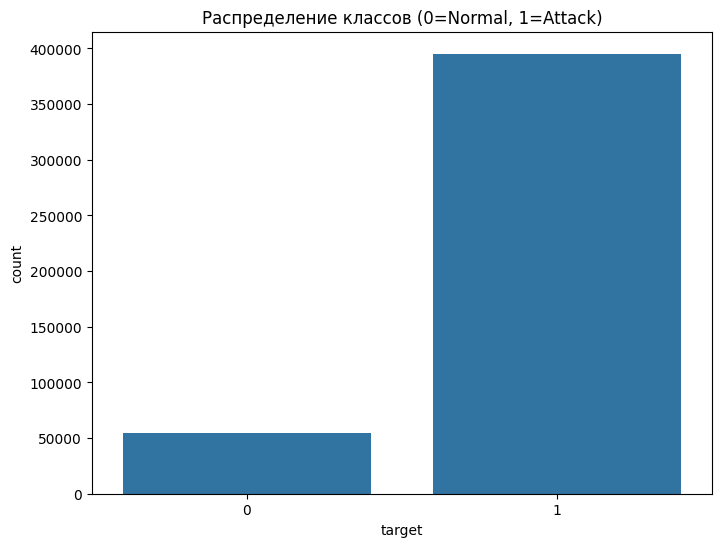

In [8]:
# Визуализация распределения классов
plt.figure(figsize=(8, 6))
sns.countplot(x=y)
plt.title('Распределение классов (0=Normal, 1=Attack)')
plt.show()
# Подтверждает наличие дисбаланса

Далее используем метод ANOVA для уменьшения размерности, а также отбора датчиков (признаков), которые сильнее всего реагируют на атаки.

Для каждого признака  вычисляет F-статистику и p-value. Чем выше F-статистика, тем сильнее признак влияет на разделение классов ("Normal" vs "Attack"). А Чем ниже p-value, тем статистически значимее различия.

In [9]:
# Проверка значимости различий
print("\nСтатистическая значимость различий (ANOVA):")
for feature in X.columns:
    f_val, p_val = f_classif(X[[feature]], y)
    print(f"{feature}: F-value = {f_val[0]:.2f}, p-value = {p_val[0]:.4f}")


Статистическая значимость различий (ANOVA):
FIT101: F-value = 40977.23, p-value = 0.0000
LIT101: F-value = 65788.87, p-value = 0.0000
MV101: F-value = 37252.63, p-value = 0.0000
P101: F-value = 58868.76, p-value = 0.0000
P102: F-value = 22258.58, p-value = 0.0000
AIT201: F-value = 3299.50, p-value = 0.0000
AIT202: F-value = 1457.19, p-value = 0.0000
AIT203: F-value = 74197.33, p-value = 0.0000
FIT201: F-value = 56262.14, p-value = 0.0000
MV201: F-value = 52711.26, p-value = 0.0000
P201: F-value = 6859.36, p-value = 0.0000
P202: F-value = nan, p-value = nan
P203: F-value = 59052.00, p-value = 0.0000
P204: F-value = 405.69, p-value = 0.0000
P205: F-value = 58220.00, p-value = 0.0000
P206: F-value = 398.44, p-value = 0.0000
DPIT301: F-value = 65349.27, p-value = 0.0000
FIT301: F-value = 102237.75, p-value = 0.0000
LIT301: F-value = 30861.19, p-value = 0.0000
MV301: F-value = 114.98, p-value = 0.0000
MV302: F-value = 74834.63, p-value = 0.0000
MV303: F-value = 99.44, p-value = 0.0000
MV30

ANOVA тест подтвердил статистическую значимость различий для большинства признаков (p-value < 0.05)


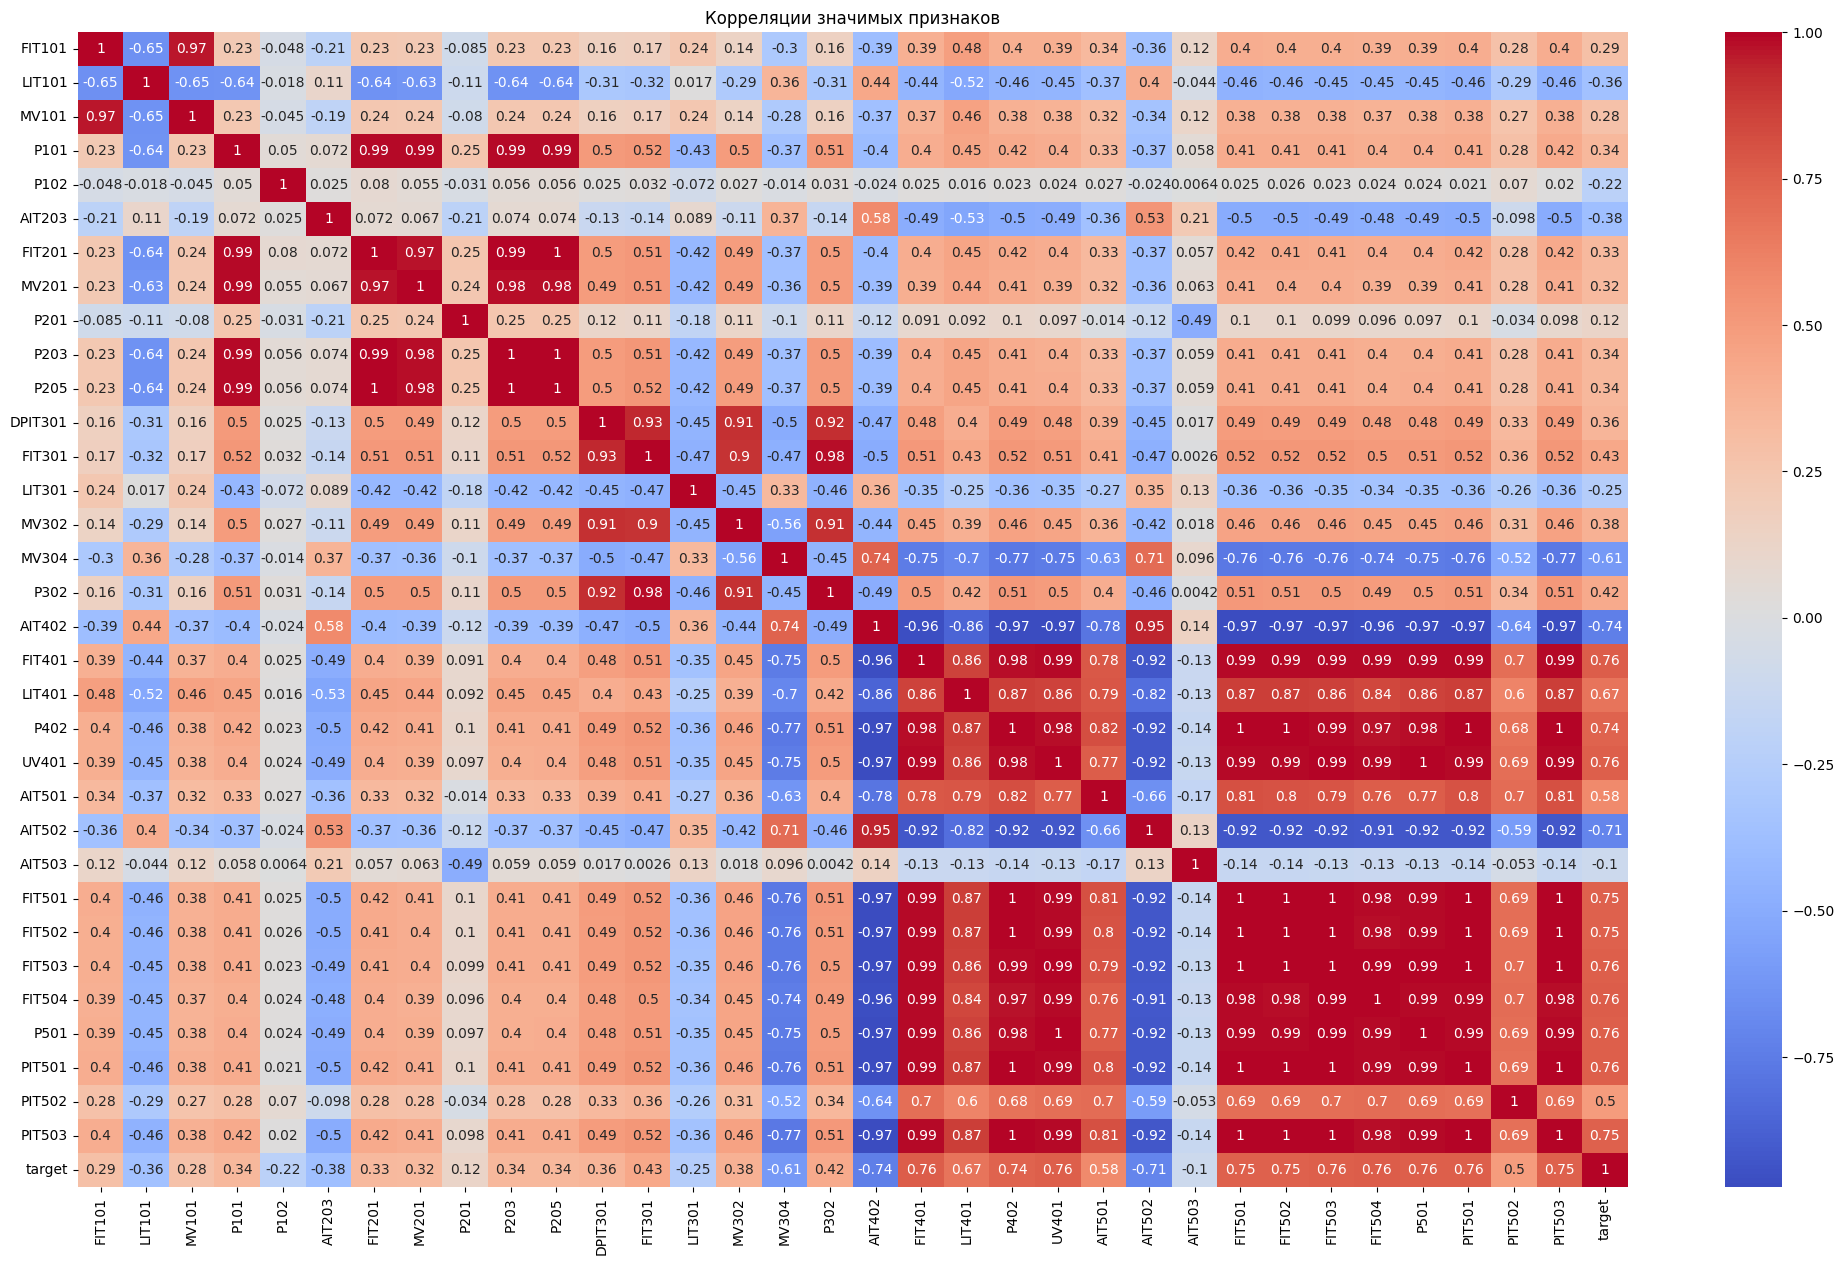

In [13]:
# Анализ корреляций признаков с целевой переменной
plt.figure(figsize=(25, 15))
corr = Z.corr()
sns.heatmap(corr[abs(corr['target']) > 0.1].loc[:, abs(corr['target']) > 0.1],
            annot=True, cmap='coolwarm')
plt.title('Корреляции значимых признаков')
plt.show()


In [14]:
# Подготовка данных для моделирования
# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42)
#Берем 70% - обучающая выборка, 30% - тестовая

In [15]:
# Масштабирование признаков с помощью стандартизации
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Ранее уже упоминалось, что данные дисбалансные. При таком дисбалансе модель может просто всегда предсказывать "Normal", но совершенно не уметь обнаруживать атаки. Поэтому используем SMOTE —  метод искусственной генерации примеров для миноритарного класса, который помогает бороться с дисбалансом данных.

Он стабилизирует данные и уменьшит переобучение (по сравнению с простым дублированием).


In [16]:
# Балансировка классов (SMOTE)
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)


Для уменьшения размерности и риска переобучения отбираем наиболее информативные признаки.

Для каждого признака вычисляется F-статистика, которая показывает насколько сильно признак различает классы (Normal/Attack). Чем выше F-value, тем важнее признак для классификации.
Признаки сортируются по F-value и выбираются 15.


In [17]:
# Отбор признаков
selector = SelectKBest(f_classif, k=15)
X_train_selected = selector.fit_transform(X_train_bal, y_train_bal)
X_test_selected = selector.transform(X_test_scaled)

Переходим непосредственно к обучению модели. Выбирала между логистической регрессие и случайным лесов, но выбрала по итогу лес, так как логистическая регрессия требует меньше данных для обучения, а случайный лес на маленьком количестве данных переобучится. У нас много данных, поэтому подойдет больше случайный лес. Плюсом неплохо работает категориальными данными.


In [18]:
# Обучение модели RandomForest
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_split=5
)

model.fit(X_train_selected, y_train_bal)


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=5, random_state=42)

In [19]:
# Предсказания
y_pred = model.predict(X_test_selected)
y_prob = model.predict_proba(X_test_selected)[:, 1]

In [20]:
# Оценка модели
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))



Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     16386
           1       0.98      0.99      0.98    118590

    accuracy                           0.97    134976
   macro avg       0.94      0.93      0.93    134976
weighted avg       0.97      0.97      0.97    134976


Confusion Matrix:
[[ 14363   2023]
 [  1774 116816]]

ROC-AUC Score: 0.9924041097464559


Модель Random Forest показала хорошее качество классификации согласно метрикам.

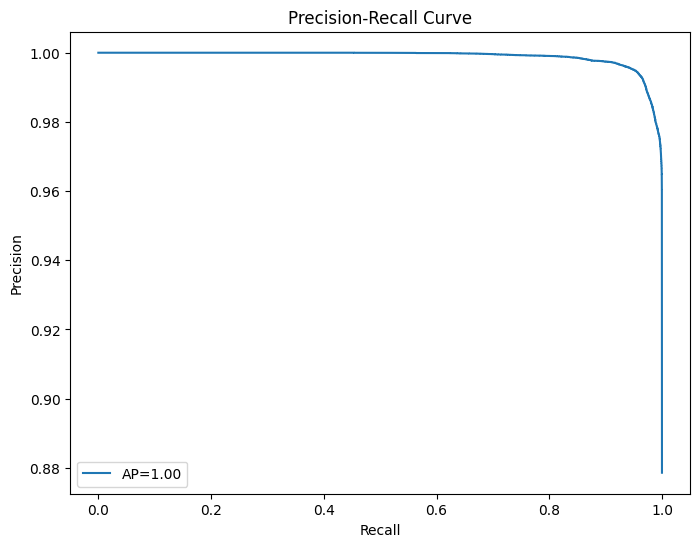

In [21]:
# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP={average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

PR-кривая показывает компромисс между точностью и полнотой модели. В данном случае PR-кривая будет информативнее ROC, так как ROC-кривая использует FPR (False Positive Rate), который может быть обманчив, если класс "Normal" огромен.

На основе кривой можно сделать вывод, что модель хорошо отделяет атаки от нормы.

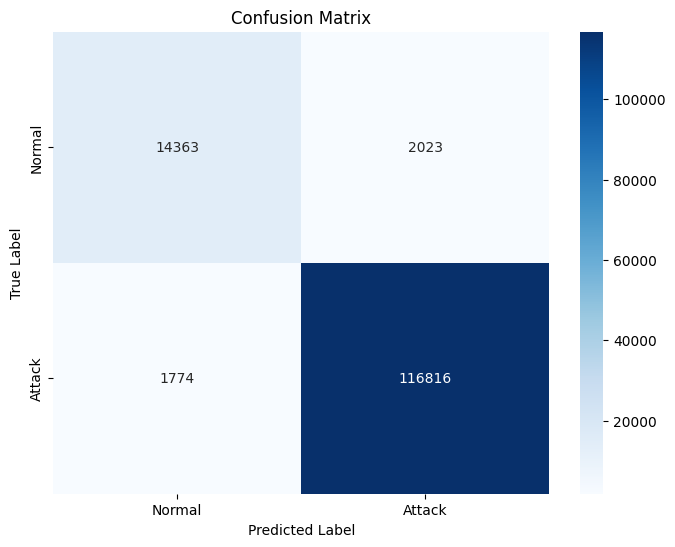

In [22]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

14363 - Правильно распознанные нормальные состояния.

2023 - Ложные срабатывания

1774 - Пропущенные атаки

116816 - Правильно обнаруженные атаки

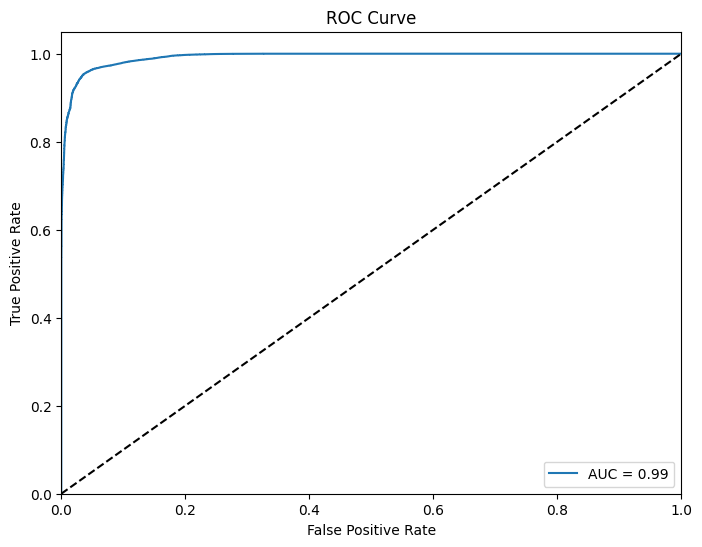

In [23]:
# ROC кривая
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Анализируя график, можно сделать вывод, что классификация проведена хорошо, так как кривая выше диагонали и близка к верхнему левому углу, а AUC > 0.9.

Далее проанализируем и визуализируем, какие признаки наиболее сильно влияют на предсказания модели случайного леса.

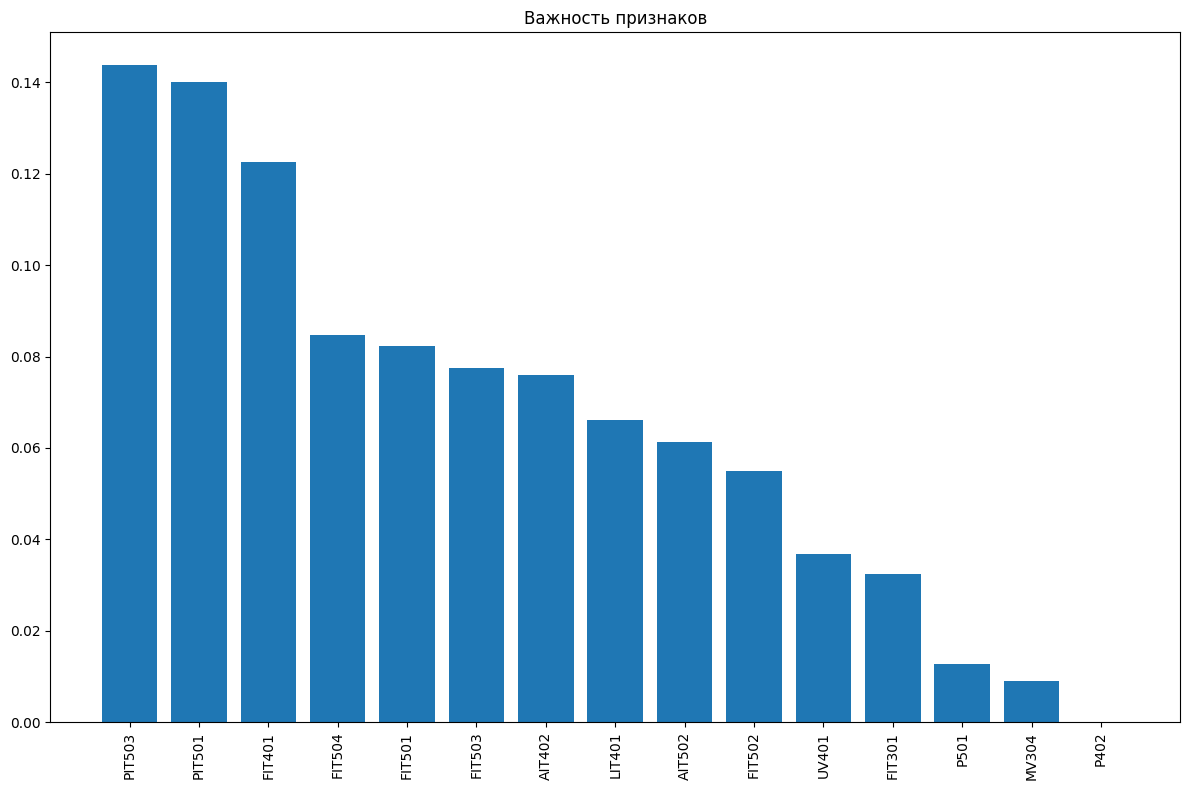

In [24]:
# Важность признаков
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns[selector.get_support()]

plt.figure(figsize=(12, 8))
plt.title('Важность признаков')
plt.bar(range(X_train_selected.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_selected.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [25]:
# Вывод наиболее важных признаков
print("\nТоп-10 важных признаков:")
for i in range(10):
    print(f"{i+1}. {features[indices[i]]}: {importances[indices[i]]:.4f}")



Топ-10 важных признаков:
1. PIT503: 0.1438
2. PIT501: 0.1400
3. FIT401: 0.1225
4. FIT504: 0.0847
5. FIT501: 0.0823
6. FIT503: 0.0775
7. AIT402: 0.0759
8. LIT401: 0.0660
9. AIT502: 0.0612
10. FIT502: 0.0550


Проведем сравнение между периодами атики и нормального существования. Возьмем самый важный показатель PIT503 и сравним его первые 100 значений.

Значения при атаке явно ниже, чем при нормале.

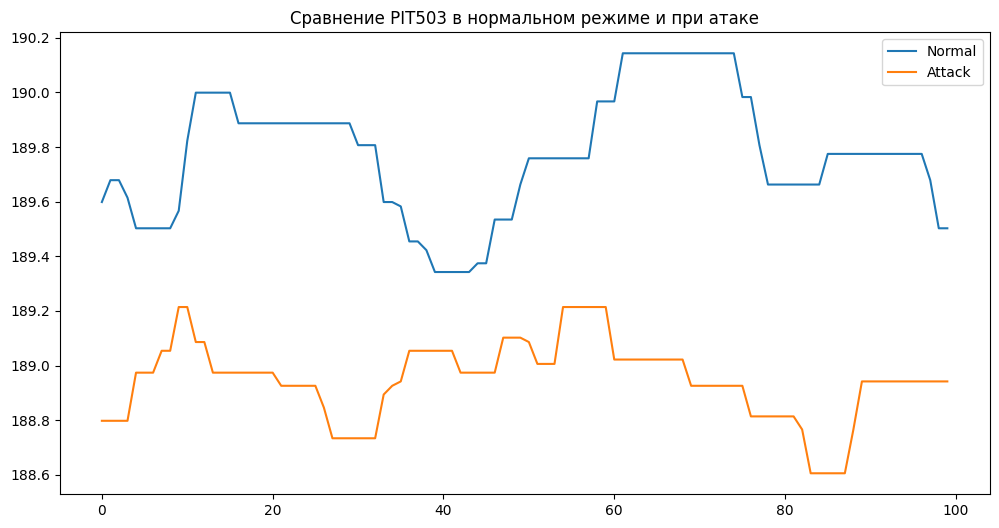

In [26]:
# Визуализация временного ряда для PIT503
plt.figure(figsize=(12, 6))
plt.plot(data[data['Normal/Attack']=='Normal']['PIT503'].values[:100], label='Normal')
plt.plot(data[data['Normal/Attack']=='Attack']['PIT503'].values[:100], label='Attack')
plt.title('Сравнение PIT503 в нормальном режиме и при атаке')
plt.legend()
plt.show()

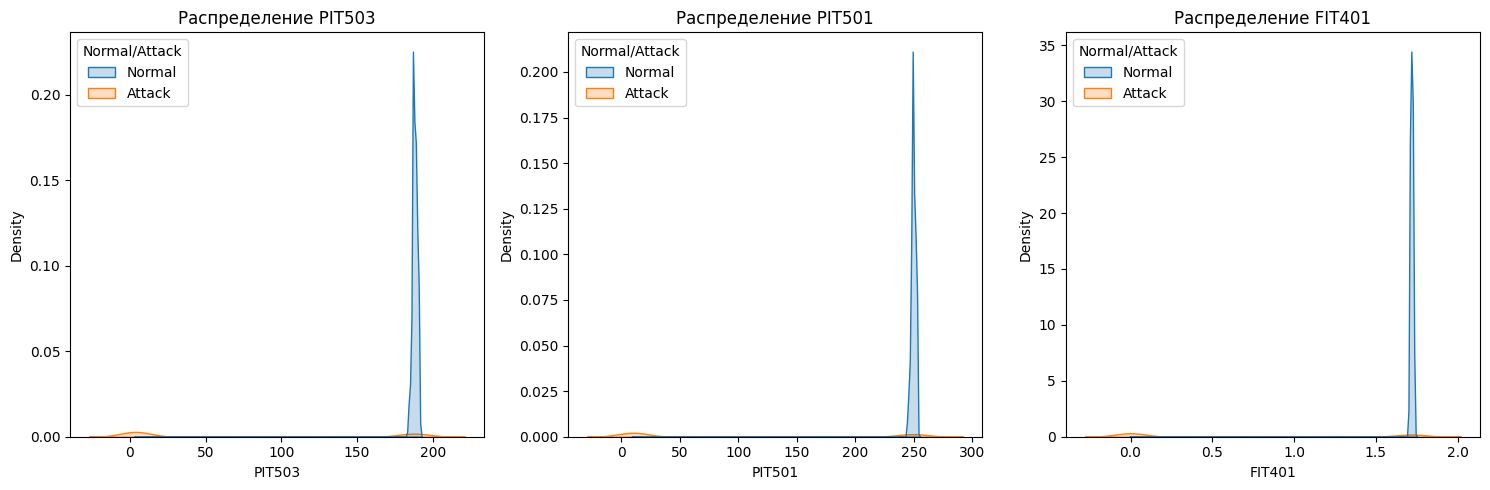

In [27]:
# Сравнение распределений для топ-3 признаков
plt.figure(figsize=(15, 5))
for i, col in enumerate(['PIT503', 'PIT501', 'FIT401'], 1):
    plt.subplot(1, 3, i)
    sns.kdeplot(data=data, x=col, hue='Normal/Attack', fill=True)
    plt.title(f'Распределение {col}')
plt.tight_layout()
plt.show()
# Построили графики ядерной оценки плотности, где кривые сильно расходятся

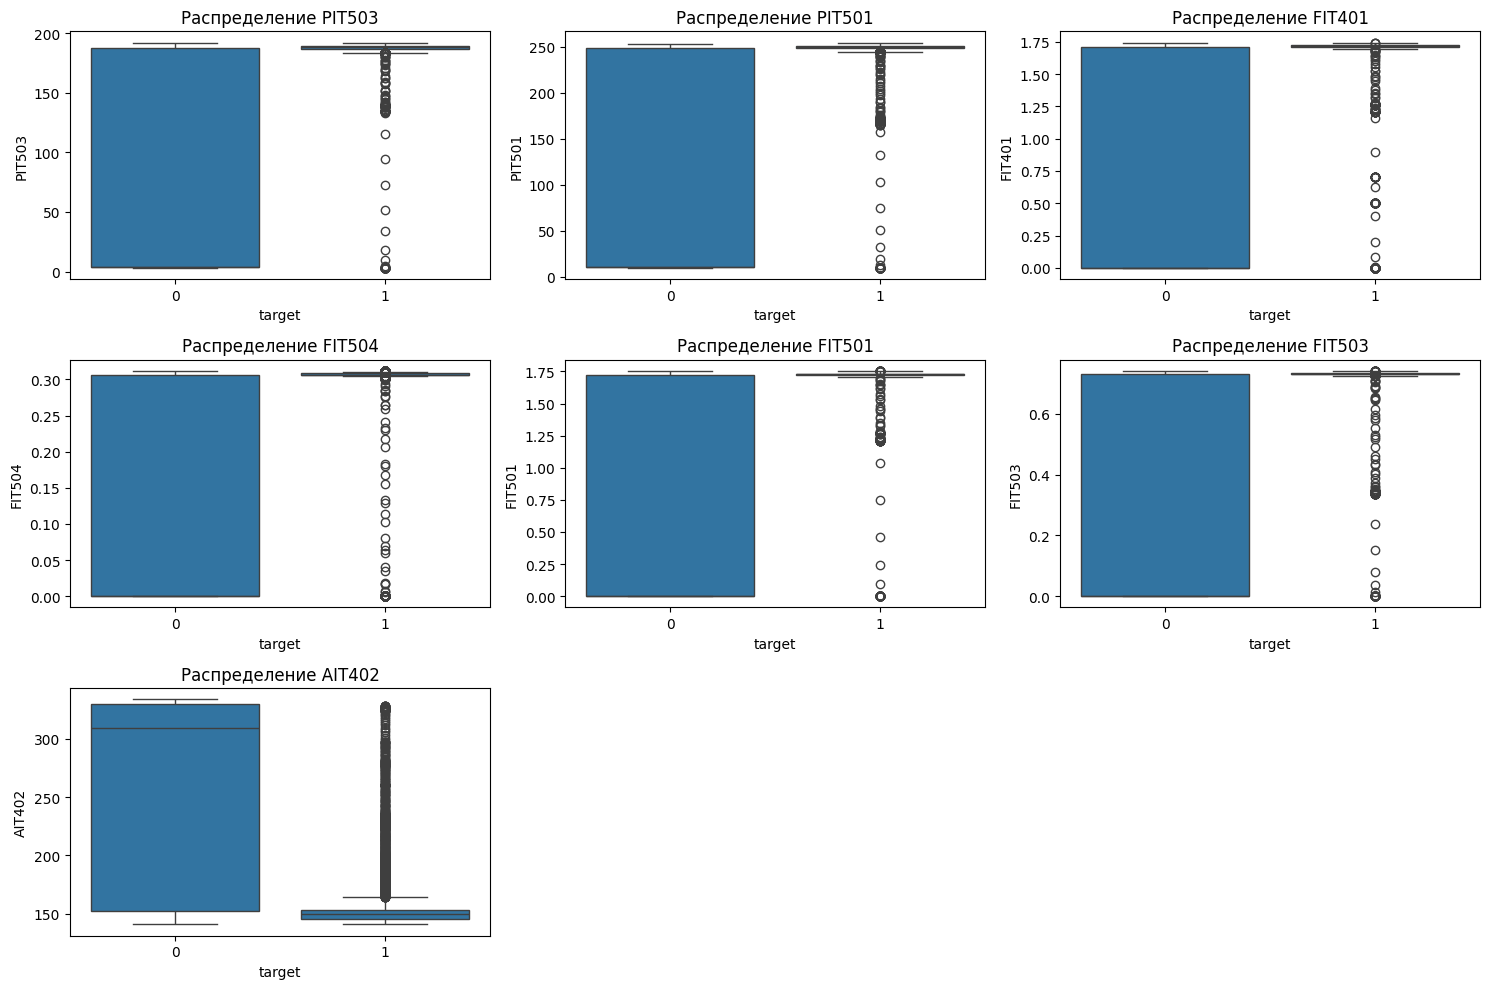

In [28]:
# Анализ различий между классами
# Выберем несколько ключевых признаков для анализа
key_features = ['PIT503', 'PIT501', 'FIT401', 'FIT504', 'FIT501', 'FIT503', 'AIT402']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=y, y=feature, data=X)
    plt.title(f'Распределение {feature}')
plt.tight_layout()
plt.show()

Анализ boxplot показал значительные различия в распределениях многих параметров между нормальным режимом и атакой.

**Выводы**

1.   Наблюдаются статистически значимые различия между нормальным режимом работы системы и атакой.
2.   Модель Random Forest с отбором признаков и балансировкой классов показала высокое качество обнаружения атак.
3. Наиболее информативными для обнаружения атак оказались параметры: PIT503, PIT501, FIT401, FIT504, FIT501, FIT503, AIT402, LIT401, AIT502, FIT502.
4. Атаки часто сопровождаются резкими скачками показаний датчиков (например, внезапное увеличение расхода без изменения статуса насосов).
